In [43]:
import re
from pathlib import Path

import numpy as np

import jax
import jax.lax
from jax.random import PRNGKey
import jax.numpy as jnp
import optax
from flax.training.train_state import TrainState
from flax import linen as nn

import matplotlib.pyplot as plt

from flax import struct
from flax.training.train_state import TrainState
from flax.core import FrozenDict
from typing import Any, Dict, Tuple

import jax, jax.numpy as jnp
from jax.random import PRNGKey
from flax import linen as nn
from typing import Tuple


from typing import Optional, Tuple, Dict, Any, Sequence


data_dir = "./data"
print(f"Data resides in        : {data_dir}")

Data resides in        : ./data


In [44]:
class MultiBasisDataLoader:
    def __init__(self, data_dict: dict[str, jnp.ndarray],
                 batch_size: int = 128,
                 shuffle: bool = True,
                 drop_last: bool = False,
                 seed: int = 0):
        lengths = [len(v) for v in data_dict.values()]
        if len(set(lengths)) != 1:
            raise ValueError(f"All arrays must have the same length, got: {lengths}")

        self.data = data_dict
        self.n = lengths[0]
        self.bs = batch_size
        self.shuffle = shuffle
        self.drop_last = drop_last
        self.rng = np.random.default_rng(seed)

        self.idx_slices = [
            (i, i + batch_size)
            for i in range(0, self.n, batch_size)
            if not drop_last or i + batch_size <= self.n
        ]

    def __iter__(self):
        self.order = np.arange(self.n)
        if self.shuffle:
            self.rng.shuffle(self.order)
        self.slice_idx = 0
        return self

    def __next__(self):
        if self.slice_idx >= len(self.idx_slices):
            raise StopIteration
        s, e = self.idx_slices[self.slice_idx]
        self.slice_idx += 1
        return {k: v[self.order[s:e]] for k, v in self.data.items()}


def load_measurements(folder: str, file_pattern: str = "w_*.txt") -> dict[str, jnp.ndarray]:
    out: dict[str, jnp.ndarray] = {}

    for fp in Path(folder).glob(file_pattern):
        basis = fp.stem.split("_")[2]

        bitstrings = []
        with fp.open() as f:
            for line in f:
                bitstring = np.fromiter((c.islower() for c in line.strip()), dtype=np.float32)
                bitstrings.append(bitstring)

        arr = jnp.asarray(np.stack(bitstrings))
        if basis in out:
            out[basis] = jnp.concatenate([out[basis], arr], axis=0)
        else:
            out[basis] = arr

    return out

In [45]:
data_dict = load_measurements("data/", "w_*.txt")

keys_amp = [k for k in data_dict if re.fullmatch(r"^Z+$", k)]
keys_pha = [k for k in data_dict if re.fullmatch(r"^(?!Z+$).*", k)]
dict_amp = {k: data_dict[k] for k in keys_amp}
dict_pha = {k: data_dict[k] for k in keys_pha}

loader_pha = MultiBasisDataLoader(dict_pha, batch_size=128)

In [46]:
class RBM(nn.Module):
    n_visible: int
    n_hidden: int
    k: int = 1
    T: float = 1.0

    def setup(self):
        self.W = self.param("W", nn.initializers.normal(0.01), (self.n_visible, self.n_hidden))
        self.b = self.param("b", nn.initializers.zeros, (self.n_visible,))
        self.c = self.param("c", nn.initializers.zeros, (self.n_hidden,))

    def __call__(self, data: jnp.ndarray, aux_vars: Dict[str, Any]) -> Tuple[jnp.ndarray, Dict[str, Any]]:
        gibbs_step_fn = lambda i, s: self._gibbs_step(s, self.W, self.b, self.c, self.T)
        gibbs_chain, key = jax.lax.fori_loop(0, self.k, gibbs_step_fn, (aux_vars["gibbs_chain"], aux_vars["key"]))
        gibbs_chain = jax.lax.stop_gradient(gibbs_chain) # cut off gradients after Gibbs sampling

        loss = jnp.mean(self._free_energy(data)) - jnp.mean(self._free_energy(gibbs_chain))
        return loss, {"gibbs_chain": gibbs_chain, "key": key}

    def _free_energy(self, v):
        return -(v @ self.b) - jnp.sum(jax.nn.softplus(v @ self.W + self.c), -1)

    @staticmethod
    def _gibbs_step(state, W, b, c, T):
        v, key = state
        key, h_key, v_key = jax.random.split(key, 3)
        h = jax.random.bernoulli(h_key, jax.nn.sigmoid((v @ W + c)/T)).astype(jnp.float32)
        v = jax.random.bernoulli(v_key, jax.nn.sigmoid((h @ W.T + b)/T)).astype(jnp.float32)
        return v, key

    @nn.nowrap
    def generate(self, n_samples: int, T_schedule: jnp.ndarray, key: PRNGKey) -> jnp.ndarray:
        key, key_init = jax.random.split(key, 2)
        v = jax.random.bernoulli(key_init, p=0.5, shape=(n_samples, self.n_visible)).astype(jnp.float32)

        anneal_fn = lambda i, s: self._gibbs_step(s, W=self.W, b=self.b, c=self.c, T=T_schedule[i])
        v_final, _ = jax.lax.fori_loop(0, len(T_schedule), anneal_fn, (v, key))
        return v_final

In [275]:
@jax.jit
def train_step_amp(
        state: TrainState,
        batch_dict: Dict[str, jnp.ndarray],
        gibbs_chain: jnp.ndarray,
        key: PRNGKey,
        p_reset: float) -> Tuple[TrainState, jnp.ndarray, jnp.ndarray, PRNGKey]:

    if len(batch_dict) != 1:
        raise ValueError("Batch dictionary must contain exactly one entry.")
    (basis_key, batch), = batch_dict.items()
    if set(basis_key) != {'Z'}:
        raise ValueError(f"Batch key must consist only of 'Z', got: {basis_key}")

    key, reset_key = jax.random.split(key)

    def maybe_reset(chain, data_batch, key, p_reset):
        reset_mask = jax.random.bernoulli(key, p=p_reset, shape=chain.shape)
        return jnp.where(reset_mask, data_batch, chain)

    reset_chain = maybe_reset(gibbs_chain, batch, reset_key, p_reset)

    aux_vars = {"gibbs_chain": reset_chain, "key": key}
    loss_fn = lambda params: state.apply_fn({'params': params}, batch, aux_vars)
    value_and_grad_fn = jax.value_and_grad(loss_fn, has_aux=True)

    (loss, aux_vars), grads = value_and_grad_fn(state.params)
    state = state.apply_gradients(grads=grads)

    return state, loss, aux_vars["gibbs_chain"], aux_vars["key"]






def train_amp_rbm_old(
        state: TrainState,
        loader: MultiBasisDataLoader,
        gibbs_chain: jnp.ndarray,
        num_epochs: int,
        key: PRNGKey,
        p_min: float = 0.02,
        p_max: float = 0.30,
        reset_gain: float = 0.5) -> Tuple[TrainState, Dict[int, float]]:

    metrics = {}

    def estimate_entropy(chain: jnp.ndarray) -> float:
        indices = jnp.argmax(chain, axis=-1)
        counts = jnp.bincount(indices, length=chain.shape[-1])
        probs = counts / jnp.sum(counts)
        entropy = -jnp.sum(jnp.where(probs > 0, probs * jnp.log(probs), 0.0))
        return entropy

    H_target = jnp.log(gibbs_chain.shape[-1])

    for epoch in range(num_epochs):
        tot_loss = 0.0
        tot_entropy = 0.0
        batches = 0

        for batch_dict in loader:
            H_chain = estimate_entropy(gibbs_chain)
            tot_entropy += float(H_chain)

            p_reset = jnp.clip(reset_gain * (H_target - H_chain), a_min=p_min, a_max=p_max)

            state, loss, gibbs_chain, key = train_step_amp(
                state, batch_dict, gibbs_chain, key, float(p_reset)
            )

            tot_loss += float(loss)
            batches += 1

        avg_loss = tot_loss / batches
        avg_entropy = tot_entropy / batches
        mode_count = float(jnp.exp(avg_entropy))

        metrics[epoch] = {
            "loss_amp": avg_loss,
            "H_chain": avg_entropy,
            "mode_count": mode_count,
        }

        print(f"Epoch {epoch+1}/{num_epochs} │ Loss: {avg_loss:.4f} │ H_chain: {avg_entropy:.2f} │ ~Modes: {mode_count:.1f}")

    return state, metrics


def train_amp_rbm(
        state: TrainState,
        loader: MultiBasisDataLoader,
        gibbs_chain: jnp.ndarray,
        num_epochs: int,
        key: PRNGKey,
        p_min: float = 0.02,
        p_max: float = 0.30,
        reset_gain: float = 0.5,
        ema_alpha: float = 0.9) -> Tuple[TrainState, Dict[int, float]]:

    metrics = {}

    def estimate_entropy(chain: jnp.ndarray) -> float:
        indices = jnp.argmax(chain, axis=-1)
        counts = jnp.bincount(indices, length=chain.shape[-1])
        probs = counts / jnp.sum(counts)
        entropy = -jnp.sum(jnp.where(probs > 0, probs * jnp.log(probs), 0.0))
        return entropy

    H_target = jnp.log(gibbs_chain.shape[-1])
    H_ema = H_target  # start from max entropy to avoid premature resets

    for epoch in range(num_epochs):
        tot_loss = 0.0
        tot_entropy = 0.0
        tot_mode_count = 0.0
        batches = 0

        for batch_dict in loader:
            H_chain = estimate_entropy(gibbs_chain)
            H_ema = float(ema_alpha * H_ema + (1 - ema_alpha) * H_chain)
            p_reset = jnp.clip(reset_gain * (H_target - H_ema), a_min=p_min, a_max=p_max)

            state, loss, gibbs_chain, key = train_step_amp(
                state, batch_dict, gibbs_chain, key, float(p_reset)
            )

            tot_entropy += float(H_chain)
            tot_loss += float(loss)
            tot_mode_count += float(jnp.exp(H_chain))
            batches += 1

        avg_loss = tot_loss / batches
        avg_entropy = tot_entropy / batches
        avg_mode_count = tot_mode_count / batches

        metrics[epoch] = {
            "loss_amp": avg_loss,
            "H_chain": avg_entropy,
            "mode_count": avg_mode_count,
        }

        print(f"Epoch {epoch+1}/{num_epochs} │ Loss: {avg_loss:.4f} │ H_chain: {avg_entropy:.2f} │ ~Modes: {avg_mode_count:.1f}")

    return state, metrics



In [335]:
# ---- hyperparameters ----
batch_size    = 64
visible_units = 10
hidden_units  = 16 # totally sufficient to capture all modes
k_steps       = 200 # more k-steps mean less variance in the loss
lr            = 1e-2
num_epochs    = 500
chains        = batch_size

key_seed = PRNGKey(42)
key, key_params, key_chains, key_dummy = jax.random.split(key_seed, 4)

model_amp = RBM(visible_units, hidden_units, k=k_steps)
batch_dummy = jnp.zeros((batch_size, visible_units), dtype=jnp.float32)
aux_vars_dummy = {"gibbs_chain": jnp.zeros((batch_size, visible_units), dtype=jnp.float32), "key": key_dummy}
variables_amp = model_amp.init({"params": key_params}, batch_dummy, aux_vars_dummy)

loader_amp = MultiBasisDataLoader(dict_amp, batch_size=batch_size)

optimizer_amp = optax.adam(learning_rate=lr)
state_amp = TrainState.create(apply_fn=model_amp.apply, params=variables_amp["params"], tx=optimizer_amp)
gibbs_chain = jax.random.bernoulli(key_chains, p=0.5, shape=(chains, visible_units)).astype(jnp.float32)

%time state_amp, metrics_amp = train_amp_rbm(state_amp, loader_amp, gibbs_chain, num_epochs, key=key, p_min=0.00, p_max=1, reset_gain=0.9)

Epoch 1/500 │ Loss: -0.3361 │ H_chain: 1.74 │ ~Modes: 5.8
Epoch 2/500 │ Loss: -0.0716 │ H_chain: 1.79 │ ~Modes: 6.0
Epoch 3/500 │ Loss: -0.0465 │ H_chain: 1.81 │ ~Modes: 6.1
Epoch 4/500 │ Loss: -0.0341 │ H_chain: 1.80 │ ~Modes: 6.1
Epoch 5/500 │ Loss: -0.0192 │ H_chain: 1.80 │ ~Modes: 6.1
Epoch 6/500 │ Loss: -0.0031 │ H_chain: 1.79 │ ~Modes: 6.0
Epoch 7/500 │ Loss: -0.0095 │ H_chain: 1.82 │ ~Modes: 6.2
Epoch 8/500 │ Loss: 0.0115 │ H_chain: 1.81 │ ~Modes: 6.1
Epoch 9/500 │ Loss: 0.0044 │ H_chain: 1.81 │ ~Modes: 6.1
Epoch 10/500 │ Loss: 0.0146 │ H_chain: 1.81 │ ~Modes: 6.1
Epoch 11/500 │ Loss: -0.0040 │ H_chain: 1.81 │ ~Modes: 6.2
Epoch 12/500 │ Loss: 0.0107 │ H_chain: 1.82 │ ~Modes: 6.2
Epoch 13/500 │ Loss: 0.0285 │ H_chain: 1.81 │ ~Modes: 6.1
Epoch 14/500 │ Loss: 0.0121 │ H_chain: 1.78 │ ~Modes: 6.0
Epoch 15/500 │ Loss: 0.0167 │ H_chain: 1.82 │ ~Modes: 6.2
Epoch 16/500 │ Loss: 0.0267 │ H_chain: 1.80 │ ~Modes: 6.1
Epoch 17/500 │ Loss: 0.0201 │ H_chain: 1.79 │ ~Modes: 6.0
Epoch 18/500 │ 

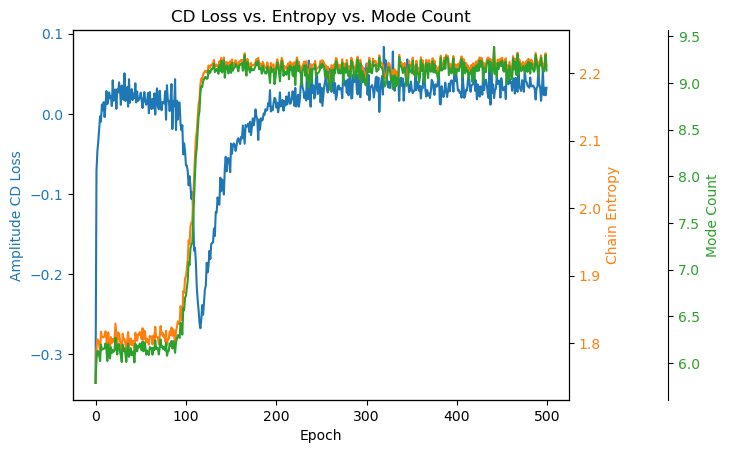

In [336]:
import matplotlib.pyplot as plt

epochs = list(metrics_amp.keys())
loss_vals = [metrics_amp[e]['loss_amp'] for e in epochs]
entropy_vals = [metrics_amp[e]['H_chain'] for e in epochs]
mode_vals = [metrics_amp[e]['mode_count'] for e in epochs]

fig, ax1 = plt.subplots()

# Left y-axis: CD loss
ax1.plot(epochs, loss_vals, label="Amplitude CD Loss", color="tab:blue")
ax1.set_xlabel("Epoch")
ax1.set_ylabel("Amplitude CD Loss", color="tab:blue")
ax1.tick_params(axis="y", labelcolor="tab:blue")

# Right y-axis: Entropy
ax2 = ax1.twinx()
ax2.plot(epochs, entropy_vals, label="Chain Entropy", color="tab:orange")
ax2.set_ylabel("Chain Entropy", color="tab:orange")
ax2.tick_params(axis="y", labelcolor="tab:orange")

# Third axis: Mode count (right side, offset)
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.2))
ax3.plot(epochs, mode_vals, label="Estimated Mode Count", color="tab:green")
ax3.set_ylabel("Mode Count", color="tab:green")
ax3.tick_params(axis="y", labelcolor="tab:green")

plt.title("CD Loss vs. Entropy vs. Mode Count")
#fig.tight_layout()
plt.show()


In [350]:
def get_cosine_schedule(T_high, T_low, n_steps):
    steps = jnp.arange(n_steps, dtype=jnp.float32)
    cos = 0.5 * (1 + jnp.cos(jnp.pi * steps / (n_steps - 1)))
    return T_low + (T_high - T_low) * cos



cosine_schedule = get_cosine_schedule(2.0, 0.4, 500)

key_sample = PRNGKey(12345)


samples = model_amp.apply(
    {"params": state_amp.params},
    n_samples=100_000,
    T_schedule=cosine_schedule,
    key=key_sample,
    method=RBM.generate
)

rel_freq = samples.mean(0)
rel_freq

Array([0.09476   , 0.07827999, 0.06243   , 0.0801    , 0.06607   ,
       0.10969   , 0.06591   , 0.10522   , 0.27131   , 0.06623   ],      dtype=float32)

In [342]:
key_sample = PRNGKey(1234)

samples = model_amp.apply(
    {"params": state_amp.params},
    n_samples=10_000,
    T_schedule=jnp.ones(300) * 1.2,
    key=key_sample,
    method=RBM.generate
)

rel_freq = samples.mean(0)
rel_freq

Array([0.1177    , 0.0922    , 0.1065    , 0.0944    , 0.0807    ,
       0.1235    , 0.0682    , 0.10969999, 0.1355    , 0.07319999],      dtype=float32)

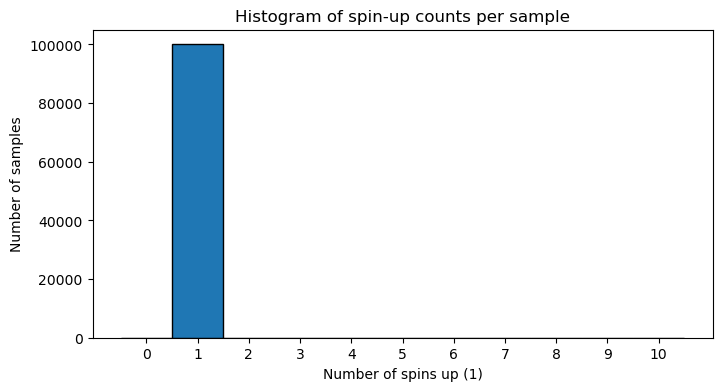

In [351]:
spin_counts = samples.sum(axis=1)

plt.figure(figsize=(8, 4))
plt.hist(spin_counts, bins=range(12), align='left', edgecolor='black')
plt.xticks(range(11))
plt.xlabel("Number of spins up (1)")
plt.ylabel("Number of samples")
plt.title("Histogram of spin-up counts per sample")
plt.show()

In [352]:
# compare with actual frequencies from first
empirical_freq = jnp.zeros(visible_units)
num_total = 0

for batch in loader_amp:
    for arr in batch.values():
        empirical_freq += jnp.sum(arr, axis=0)
        num_total += arr.shape[0]

empirical_freq = empirical_freq / num_total
empirical_freq

Array([0.0959375 , 0.09953125, 0.09640625, 0.0984375 , 0.09984375,
       0.10265625, 0.09671875, 0.101875  , 0.109375  , 0.09921875],      dtype=float32)

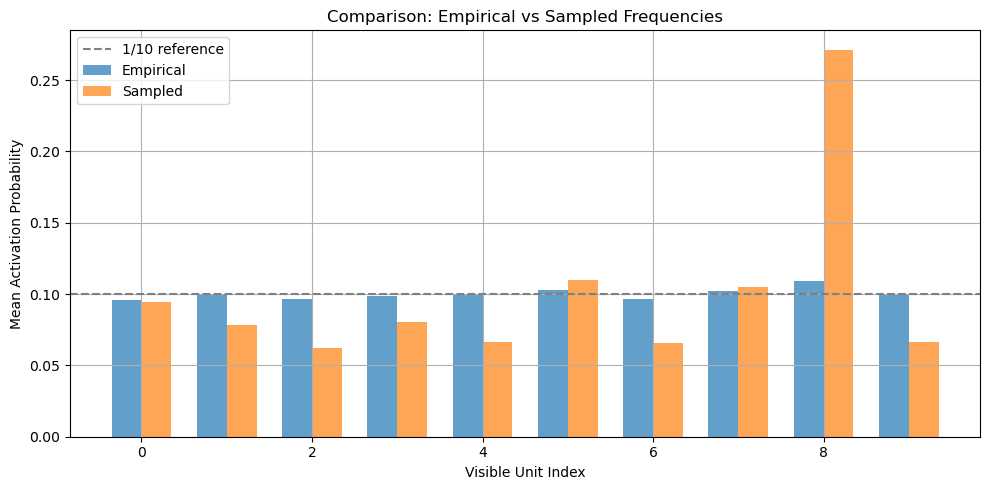

In [353]:
# Plotting comparison
plt.figure(figsize=(10, 5))
x = np.arange(visible_units)
width = 0.35

plt.bar(x - width/2, empirical_freq, width, label="Empirical", alpha=0.7)
plt.bar(x + width/2, rel_freq, width, label="Sampled", alpha=0.7)
plt.axhline(1 / visible_units, linestyle='--', color='gray', label=f'1/{visible_units} reference')
plt.xlabel("Visible Unit Index")
plt.ylabel("Mean Activation Probability")
plt.title("Comparison: Empirical vs Sampled Frequencies")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()